In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np

##Load MNIST dataset

In [ ]:
def load_mnist_dataset():
	((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
	data = np.vstack([trainData, testData])
	labels = np.hstack([trainLabels, testLabels])
	# return a 2-tuple of the MNIST data and labels
	return (data, labels)

In [ ]:
import matplotlib
matplotlib.use("Agg")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
EPOCHS = 50
INIT_LR = 1e-1
BS = 128

In [ ]:
#A-sample1

In [ ]:
"""label[0]=A
images[0]=A"""

##Load A-Z Handwritten dataset
link of the dataset  :-

In [ ]:
def load_az_dataset(datasetPath):
  data = []
  labels = []
  for row in open(datasetPath):
    row = row.split(",")
    label = int(row[0])
    image = np.array([int(x) for x in row[1:]], dtype="uint8")
    image = image.reshape((28, 28))
    data.append(image)
    labels.append(label)
  data = np.array(data, dtype='float32')
  labels = np.array(labels, dtype="int")
  return (data, labels)

In [ ]:
(digitsData, digitsLabels) = load_mnist_dataset()
(azData, azLabels) = load_az_dataset('/gdrive/MyDrive/Colab Notebooks/OCR/Data/A_Z Handwritten Data.csv')


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
digitsData[0].shape

(28, 28)

In [ ]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10
# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])
# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")
# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

In [ ]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

##Data Augmentation

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")


##Building Resnet Architecture

In [ ]:
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# check if we are utilizing the CIFAR dataset
		if dataset == "cifar":
			# apply a single CONV layer
			x = Conv2D(filters[0], (3, 3), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)

		# check to see if we are using the Tiny ImageNet dataset
		elif dataset == "tiny_imagenet":
			# apply CONV => BN => ACT => POOL to reduce spatial size
			x = Conv2D(filters[0], (5, 5), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)
			x = BatchNormalization(axis=chanDim, epsilon=bnEps,
				momentum=bnMom)(x)
			x = Activation("relu")(x)
			x = ZeroPadding2D((1, 1))(x)
			x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

In [ ]:
print("[INFO] compiling model...")
opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
model.load_weights('/gdrive/MyDrive/Colab Notebooks/OCR/Models/OCR_Resnet')

##Fit the model

In [ ]:
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training network...
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
2765/2765 [==============================] - 257s 75ms/step - loss: 3.8009 - accuracy: 0.7604 - val_loss: 0.5536 - val_accuracy: 0.8853
Epoch 2/50
2765/2765 [==============================] - 208s 75ms/step - loss: 0.9451 - accuracy: 0.9279 - val_loss: 0.5403 - val_accuracy: 0.8959
Epoch 3/50
2765/2765 [==============================] - 205s 74ms/step - loss: 0.8560 - accuracy: 0.9351 - val_loss: 0.5680 - val_accuracy: 0.8812
Epoch 4/50
2765/2765 [==============================] - 204s 74ms/step - loss: 0.8139 - accuracy: 0.9387 - val_loss: 0.5452 - val_accuracy: 0.8866
Epoch 5/50
2765/2765 [==============================] - 208s 75ms/step - loss: 0.7923 - accuracy: 0.9395 - val_loss: 0.5879 - val_accuracy: 0.8628
Epoch 6/50
2765/2765 [==============================] - 205s 74ms/step - loss: 0.7678 - accuracy: 0.

##Evaluate model

In [ ]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.40      0.63      0.49      1381
           1       0.98      0.99      0.98      1575
           2       0.91      0.97      0.94      1398
           3       0.99      0.99      0.99      1428
           4       0.92      0.98      0.95      1365
           5       0.68      0.94      0.79      1263
           6       0.95      0.98      0.97      1375
           7       0.97      0.99      0.98      1459
           8       0.98      0.99      0.98      1365
           9       0.99      0.98      0.99      1392
           A       1.00      0.99      1.00      2774
           B       0.99      0.99      0.99      1734
           C       0.99      0.98      0.99      4682
           D       0.89      0.99      0.93      2027
           E       0.99      0.99      0.99      2288
           F       0.98      0.99      0.98       232
           G       0.98      0.95      0.97      115

##Save model

In [ ]:
model.save('OCR_Resnet.h5',save_format=".h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.save('/gdrive/MyDrive/Colab Notebooks/OCR/Models/OCR_Resnet_keras',save_format=".keras")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /gdrive/MyDrive/Colab Notebooks/OCR/Models/OCR_Resnet_keras/assets


##Load model

In [ ]:
# save the model to disk
print("[INFO] serializing network...")
#model.save('first_model', save_format="h5")
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
#plt.savefig('plot')

[INFO] serializing network...


NameError: ignored

In [ ]:
output = ""

##Output

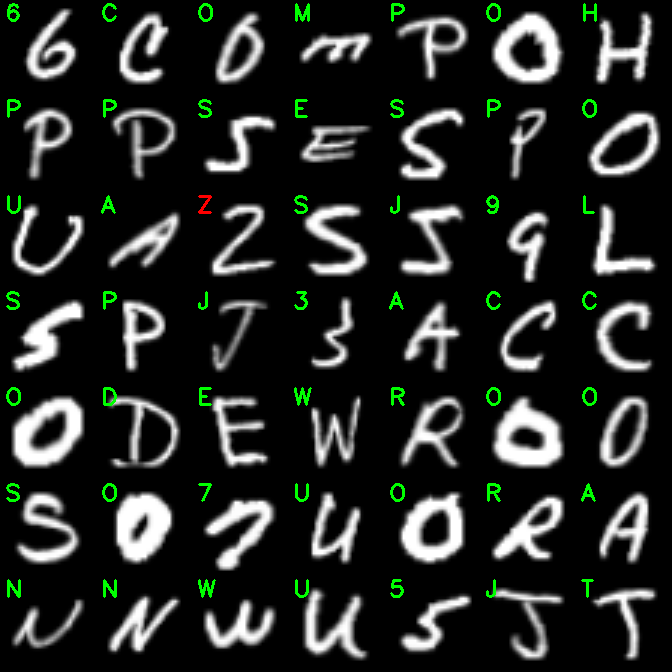

-1

In [ ]:
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
  probs = model.predict(testX[np.newaxis, i])
  prediction = probs.argmax(axis=1)
  label = labelNames[prediction[0]]
  output+=label
  image = (testX[i] * 255).astype("uint8")
  color = (0, 255, 0)
  if prediction[0] != np.argmax(testY[i]):
    color = (0, 0, 255)
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
  images.append(image)
montage = build_montages(images, (96, 96), (7, 7))[0]
cv2_imshow(montage)
cv2.waitKey(0)


In [ ]:
output

'6COMPOHPPSESPOUAZSJ9LSPJ3ACCODEWROOSO7UORANNWU5JT'

##For Deployment

In [ ]:
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
  probs = model.predict(testX[np.newaxis, i])
  prediction = probs.argmax(axis=1)
  label = labelNames[prediction[0]]
  output+=label
  """image = (testX[i] * 255).astype("uint8")
  color = (0, 255, 0)
  if prediction[0] != np.argmax(testY[i]):
    color = (0, 0, 255)
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
  images.append(image)
montage = build_montages(images, (96, 96), (7, 7))[0]
cv2_imshow(montage)
cv2.waitKey(0)"""

In [ ]:
output

'DES9HCLUOJCPOPC1OSSP2XTS36OPWTOSZO7E6OXSUTOSSATAM'

In [ ]:
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2

In [ ]:
loaded_model = load_model('/gdrive/MyDrive/Colab Notebooks/OCR/Models/OCR_Resnet.h5')

In [ ]:
image = cv2.imread('/content/abc.jpeg')

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

In [ ]:
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

In [ ]:
chars = []

In [ ]:
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape
		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)
   # re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)
		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))
		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)
		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

In [ ]:
#path='/content/abc.jpeg'

In [ ]:
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#blurred = cv2.GaussianBlur(gray, (5, 5), 0)

In [ ]:
#padded = cv2.copyMakeBorder(blurred, top=dY, bottom=dY,
#			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
#			value=(0, 0, 0))
#padded = cv2.resize(padded, (32, 32))

In [ ]:
final_image=np.expand_dims(padded,axis=2)

In [ ]:
final_image.shape

(32, 32, 1)

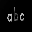

In [ ]:
cv2_imshow(final_image)

In [ ]:
#chars = np.array([c[0] for c in chars], dtype="float32")

In [ ]:
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model
preds = loaded_model.predict(chars)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]


In [ ]:
output=""

[INFO] 5 - 47.17%


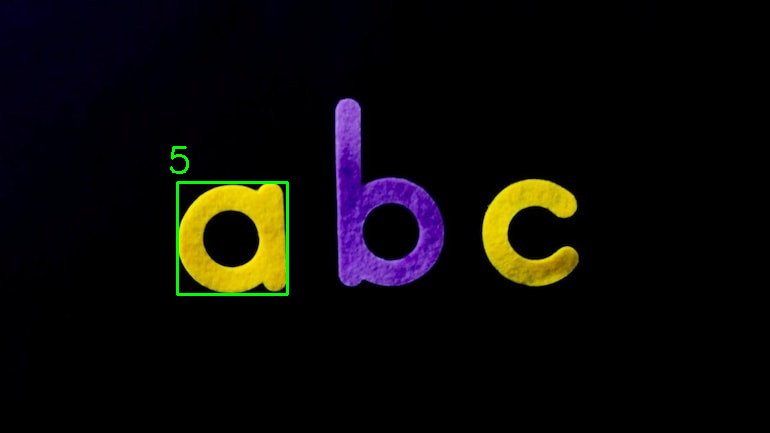

[INFO] 1 - 96.78%


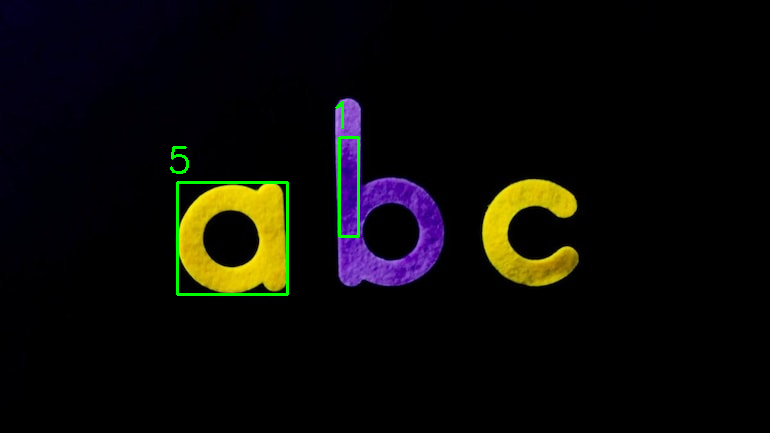

[INFO] 1 - 47.88%


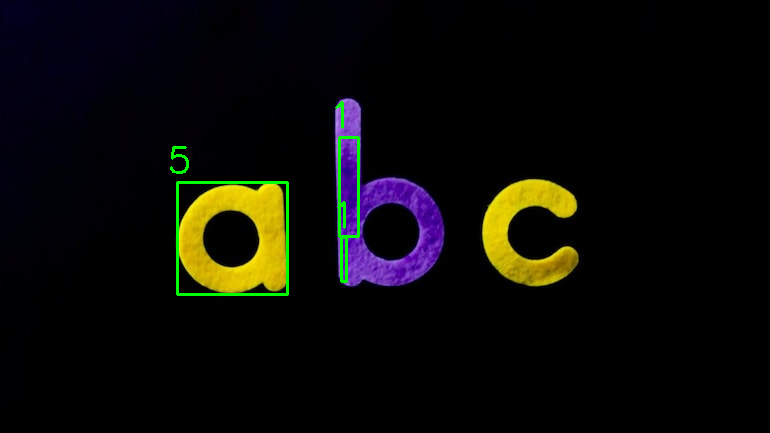

[INFO] G - 99.13%


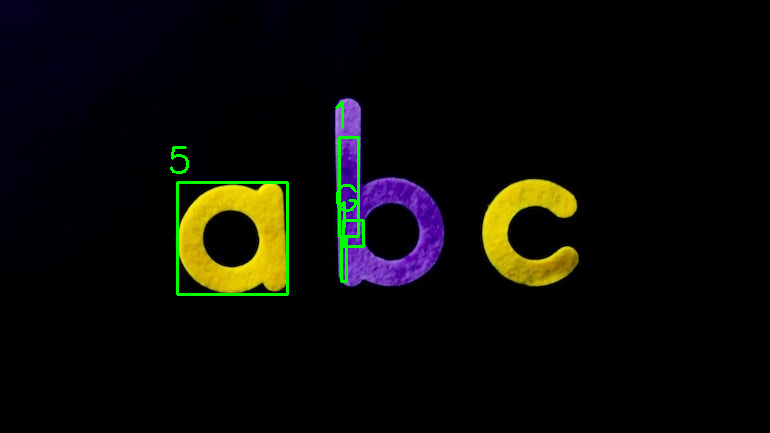

[INFO] 0 - 64.69%


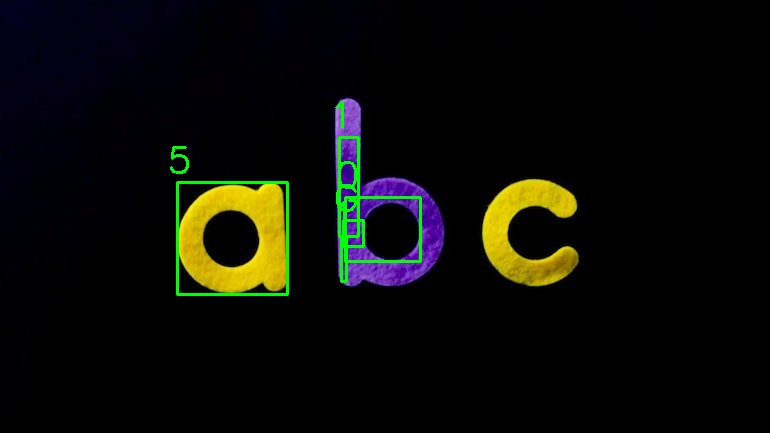

[INFO] H - 47.30%


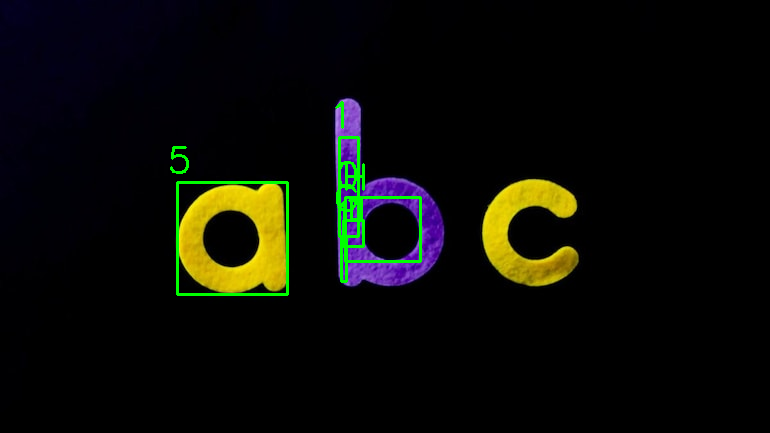

[INFO] 2 - 32.00%


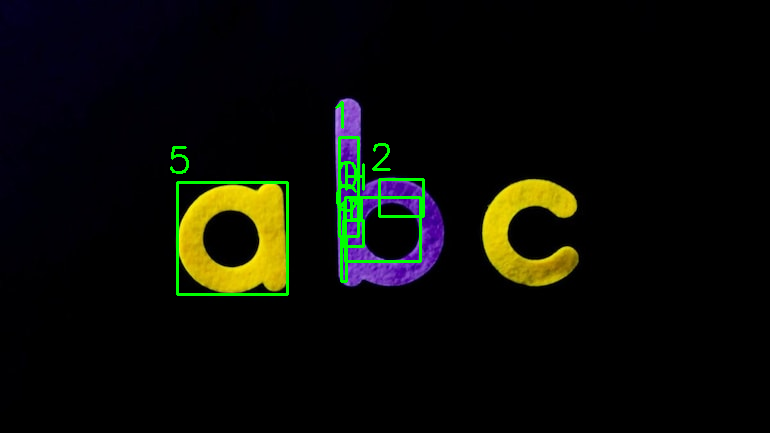

[INFO] U - 47.80%


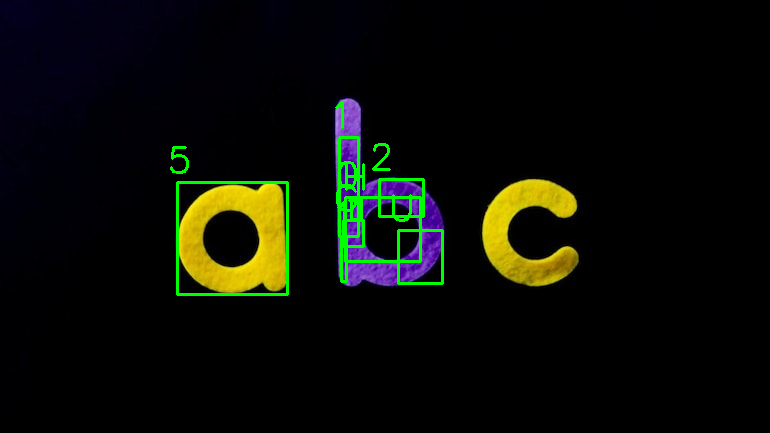

[INFO] M - 71.73%


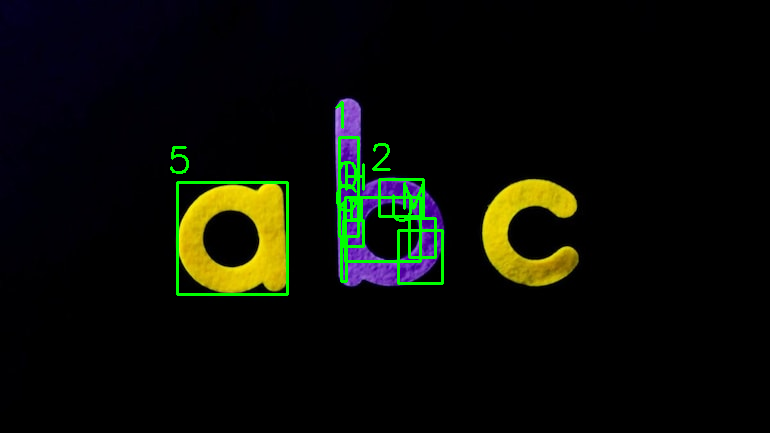

[INFO] 5 - 32.90%


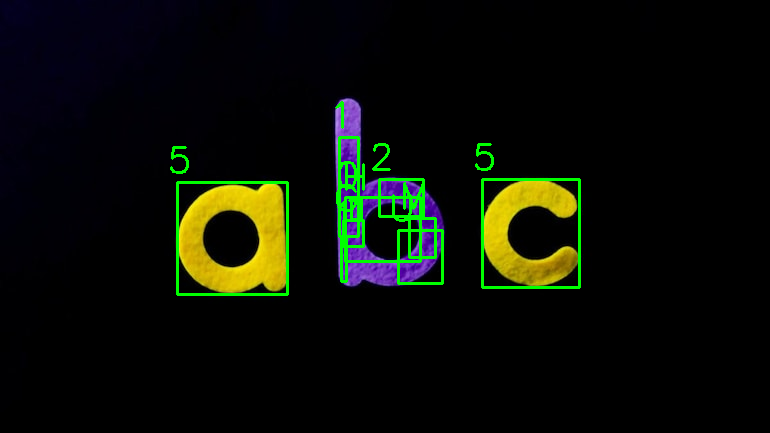

In [ ]:
for (pred, (x, y, w, h)) in zip(preds, boxes):
  i = np.argmax(pred)
  prob = pred[i]
  label = labelNames[i]
  output+=label
  print("[INFO] {} - {:.2f}%".format(label, prob * 100))
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
  cv2.putText(image, label, (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
  cv2_imshow(image)
  cv2.waitKey(0)

In [ ]:
output

'511G0H2UM5'